# eclipse depth constraint

## timmy-lite

In [2]:
import sys
sys.path.append('../../timmy-lite')
from timmy.multicolor_tess import run_bulk_depth_color_grids
from timmy.multicolor_tess import get_delta_obs_given_mstars

In [3]:
import pandas as pd

viable = pd.read_csv('../../timmy-lite/results/multicolor_I2.csv')

<AxesSubplot:xlabel='m2'>

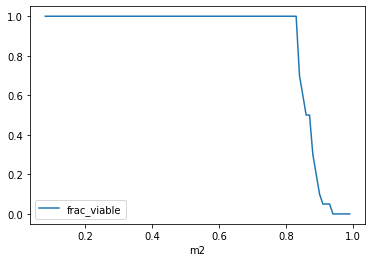

In [4]:
viable.plot(x='m2',y='frac_viable')

In [5]:
m2,m3 = 0.1, 0.1
delta_obs_dict = get_delta_obs_given_mstars(m2, m3, verbose=False)

for d in delta_obs_dict:
    print(f"{d}: {delta_obs_dict[d]:.4f}")
ratio=delta_obs_dict['Spitzer_I2']/delta_obs_dict['TESS']
print(f"delta_I2/delta_tess={ratio:.4f}")

TESS: 0.0012
Spitzer_I2: 0.0102
delta_I2/delta_tess=8.4437


In [5]:
m2,m3 = 0.1, 0.1
delta_obs_dict = get_delta_obs_given_mstars(m2, m3, imp_par=1.0, verbose=False)

for d in delta_obs_dict:
    print(f"{d}: {delta_obs_dict[d]:.4f}")
ratio=delta_obs_dict['Spitzer_I2']/delta_obs_dict['TESS']
print(f"delta_I2/delta_tess={ratio:.4f}")

TESS: 0.0005
Spitzer_I2: 0.0040
delta_I2/delta_tess=8.4437


In [6]:
import numpy as np

for m in np.arange(0.1,1,0.1):
    delta_obs_dict = get_delta_obs_given_mstars(m, m, verbose=False)

#     for d in delta_obs_dict:
#         print(f"{d}: {delta_obs_dict[d]:.4f}")
    ratio=delta_obs_dict['Spitzer_I2']/delta_obs_dict['TESS']
    print(f"m2=m3={m:.2f} delta_I2/delta_tess={ratio:.4f}")

m2=m3=0.10 delta_I2/delta_tess=8.4437
m2=m3=0.20 delta_I2/delta_tess=4.3747
m2=m3=0.30 delta_I2/delta_tess=3.3963
m2=m3=0.40 delta_I2/delta_tess=2.7344
m2=m3=0.50 delta_I2/delta_tess=2.1191
m2=m3=0.60 delta_I2/delta_tess=1.6529
m2=m3=0.70 delta_I2/delta_tess=1.2533
m2=m3=0.80 delta_I2/delta_tess=1.0786
m2=m3=0.90 delta_I2/delta_tess=0.9843


In [7]:
import numpy as np
from tqdm import tqdm
import chronos as cr

bands = ['TESS','Spitzer_I2']
m2s = np.linspace(0.08,1.0,20)
m3s = m2s.copy()

mass_grids2 = {}
tshape_grids2 = {}
for impact_param in [0, 0.5, 0.9]:
    mass_grids = {}
    tshape_grids = {}
    for band in bands:
        mass_grid = np.zeros((len(m3s), len(m2s)))
        tshape_grid = mass_grid.copy()
        for i,m2 in tqdm(enumerate(m2s)):
            for j,m3 in enumerate(m3s):
                if m2>=m3:
                    #depth
                    delta_obs_dict = get_delta_obs_given_mstars(m2, m3, imp_par=impact_param, verbose=False)
                    mass_grid[j,i] = delta_obs_dict[band]
                    #transit shape
                    rprs = np.sqrt(tshape_grid)
                    tshape = cr.transit.tshape_approx(rprs, b=impact_param)
                    tshape_grid[j,i] = delta_obs_dict[band]

            mass_grids[band] = mass_grid
            tshape_grids[band] = tshape_grid
    mass_grids2[impact_param] = mass_grids
    tshape_grids2[impact_param] = tshape_grids

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


20it [00:06,  1.80it/s]
20it [00:06,  1.76it/s]
20it [00:06,  1.74it/s]
20it [00:06,  1.74it/s]
20it [00:06,  1.73it/s]
20it [00:07,  1.70it/s]


In [8]:
mass_grids2.keys() #impact param

dict_keys([0, 0.5, 0.9])

In [9]:
import flammkuchen as dd

df = dd.load('../data/phot/allesfit_transit_results.h5')

In [10]:
from uncertainties import ufloat

df_spitzer_depth = df['spitzer']['posterior_samples']['b_rr']**2
df_tess_depth = df['tess2']['posterior_samples']['b_rr']**2

depth_spitzer = ufloat(df_spitzer_depth.median(), df_spitzer_depth.std())
depth_spitzer

0.001013593995607929+/-3.9866173297381735e-05

In [11]:
depth_tess = ufloat(df_tess_depth.median(), df_tess_depth.std())
depth_tess

0.0009623806830037186+/-5.2517646028224885e-05

In [12]:
depth_spitzer/depth_tess

1.0532152333361127+/-0.07084712179830677

In [13]:
obs_depths = {'TESS': depth_tess, #0.001078, 
              'Spitzer_I2': depth_spitzer, #0.001051 
             }

obs_tshapes = {}
for imp_par in tshape_grids2.keys():
    obs_tshape = {}
    for key in obs_depths.keys():
        rprs = obs_depths[key]**0.5
        obs_tshape[key] = cr.transit.tshape_approx(rprs, b=imp_par)
    obs_tshapes[imp_par] = obs_tshape

In [14]:
obs_depths

{'TESS': 0.0009623806830037186+/-5.2517646028224885e-05,
 'Spitzer_I2': 0.001013593995607929+/-3.9866173297381735e-05}

In [15]:
obs_tshapes

{0: {'TESS': 0.9398223253586527+/-0.001592559688031547,
  'Spitzer_I2': 0.938290657782716+/-0.0011761165179591418},
 0.5: {'TESS': 0.9205271560663293+/-0.0020840606912485918,
  'Spitzer_I2': 0.9185232208703957+/-0.0015384172621432431},
 0.9: {'TESS': 0.713822702505649+/-0.007003658240543536,
  'Spitzer_I2': 0.7070951870096329+/-0.0051595247562565855}}

In [16]:
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors

class MidPointLogNorm(mcolors.LogNorm):
    """
    Log normalization with midpoint offset

    from
    https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = (
            [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)],
            [0, 0.5, 1],
        )
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def plot_likelihood_grid(mass_grid, m2s, m3s, cmap="default", 
                         use_norm_cbar=False, reference=1,
                         label="", aspect_ratio=1):
    """
    Parameters
    ----------
    mass_grid : 3-d array
        mass grid of likelihood values
    """
    fig, ax = pl.subplots(1, 1, figsize=(8, 8))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]

    vmin, vmax = np.nanmin(mass_grid), np.nanmax(mass_grid)
    if use_norm_cbar:
        norm = MidPointLogNorm(
           vmin=vmin, vmax=vmax, midpoint=reference
        )
    else:
        norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=reference, vmax=vmax)
    # plot matrix
    cbar = ax.imshow(
        mass_grid,
        origin="lower",
        interpolation="none",
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap,
        norm=norm
    )
    pl.colorbar(
        cbar, ax=ax, label=label, orientation="vertical"  # shrink=0.9,
    )

    # add labels
    ax.set_aspect(aspect_ratio)
    pl.setp(
        ax,
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        xlabel="secondary star mass (Msun)",
        ylabel="tertiary star mass (Msun)",
    )
    # ax.set_title(label)
    return fig

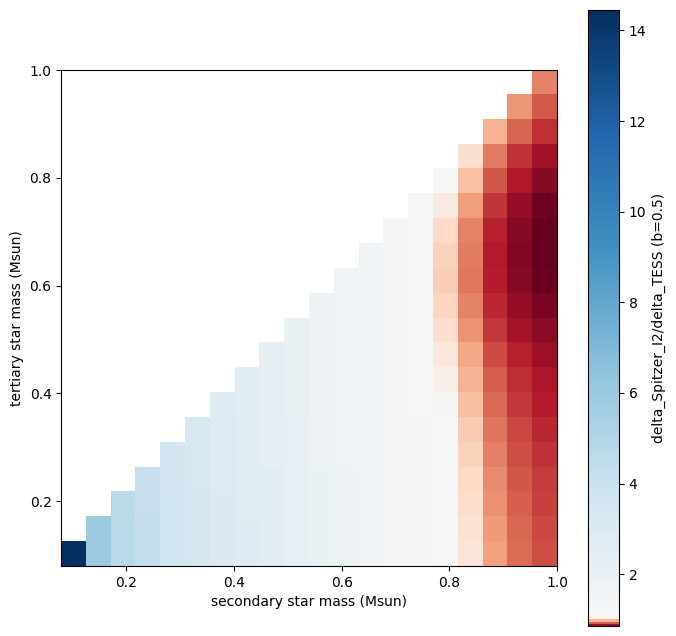

In [17]:
imp_par = 0.5
mass_grids = mass_grids2[imp_par]

bp1, bp2 = 'Spitzer_I2', 'TESS'
label = f'delta_{bp1}/delta_{bp2} (b={imp_par})'
grid = mass_grids[bp1]/mass_grids[bp2]
depth_ratio = obs_depths[bp1]/obs_depths[bp2] 

fig = plot_likelihood_grid(grid, 
                          m2s, m3s, 
                          reference=depth_ratio.nominal_value,
                          label=label, 
                          use_norm_cbar=False,
                          cmap='RdBu'
                         )

In [18]:
np.nanmin(grid), np.nanmax(grid)

(0.8567065850103527, 14.450897090960234)

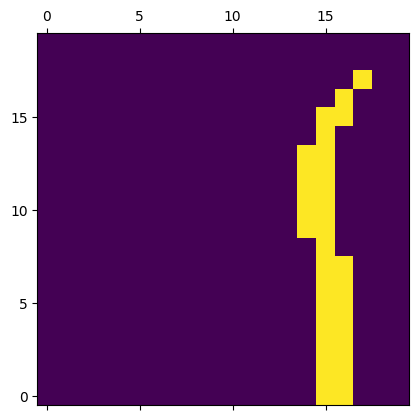

In [19]:
rtol = depth_ratio.std_dev/depth_ratio.nominal_value
idx = np.isclose(grid, depth_ratio.nominal_value, rtol=rtol)

xmin, xmax = m2s[0], m2s[-1]
ymin, ymax = m3s[0], m3s[-1]
    
pl.matshow(idx, origin="lower")

Text(0.5, 1.0, 'obs. depth ratio=1.05+/-0.07')

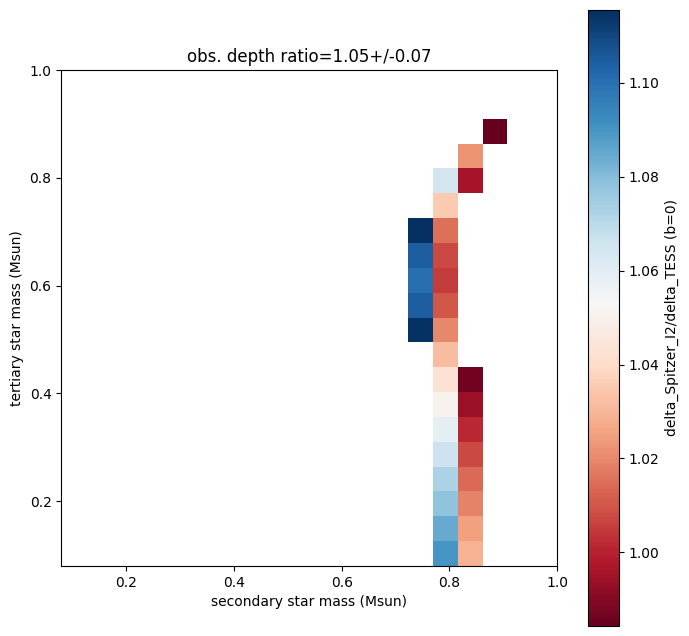

In [67]:
imp_par = 0
mass_grids = mass_grids2[imp_par]

bp1, bp2 = 'Spitzer_I2', 'TESS'
label = f'delta_{bp1}/delta_{bp2} (b={imp_par})'
grid = mass_grids[bp1]/mass_grids[bp2]


depth_ratio = obs_depths[bp1]/obs_depths[bp2] 
rtol = depth_ratio.std_dev/depth_ratio.nominal_value
idx = np.isclose(grid, depth_ratio.nominal_value, rtol=rtol)

fig = plot_likelihood_grid(np.ma.array(grid, mask=~idx), 
                          m2s, m3s, 
                          reference=depth_ratio.nominal_value,
                          label=label, 
                          use_norm_cbar=False,
                          cmap='RdBu'
                         )
fig.axes[0].set_title(f"obs. depth ratio={depth_ratio:.2f}")

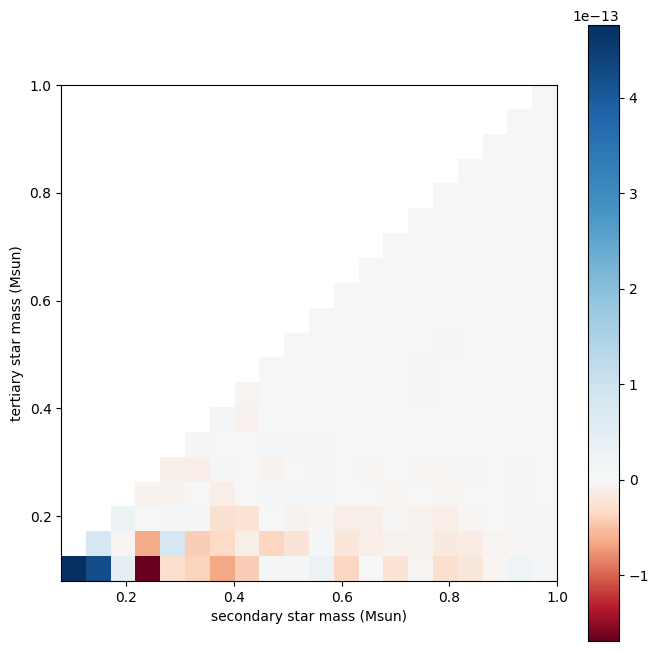

In [21]:
bp1, bp2 = 'Spitzer_I2', 'TESS'

imp_par = 0 
grid1 = mass_grids2[imp_par][bp1]/mass_grids2[imp_par][bp2]
imp_par = 0.5
grid2 = mass_grids2[imp_par][bp1]/mass_grids2[imp_par][bp2]

fig = plot_likelihood_grid(grid1-grid2, 
                          m2s, m3s, 
                          reference=0,
                          #label=label, 
                          use_norm_cbar=False,
                          cmap='RdBu'
                         )

## tshape

In [64]:
tshape=cr.transit.tshape_approx(depth_tess**0.5)
cr.transit.max_k(tshape)

0.031022261087865894+/-0.0008464509707960445

In [35]:
obs_tshapes

{0: {'TESS': 0.9398223253586527+/-0.001592559688031547,
  'Spitzer_I2': 0.938290657782716+/-0.0011761165179591418},
 0.5: {'TESS': 0.9205271560663293+/-0.0020840606912485918,
  'Spitzer_I2': 0.9185232208703957+/-0.0015384172621432431},
 0.9: {'TESS': 0.713822702505649+/-0.007003658240543536,
  'Spitzer_I2': 0.7070951870096329+/-0.0051595247562565855}}

In [46]:
np.nanmax(grid), np.nanmin(grid)

0.3730510747032878

In [45]:
tshape.nominal_value

0.938290657782716

Text(0.5, 1.0, 'obs. transit shape=0.94+/-0.00')

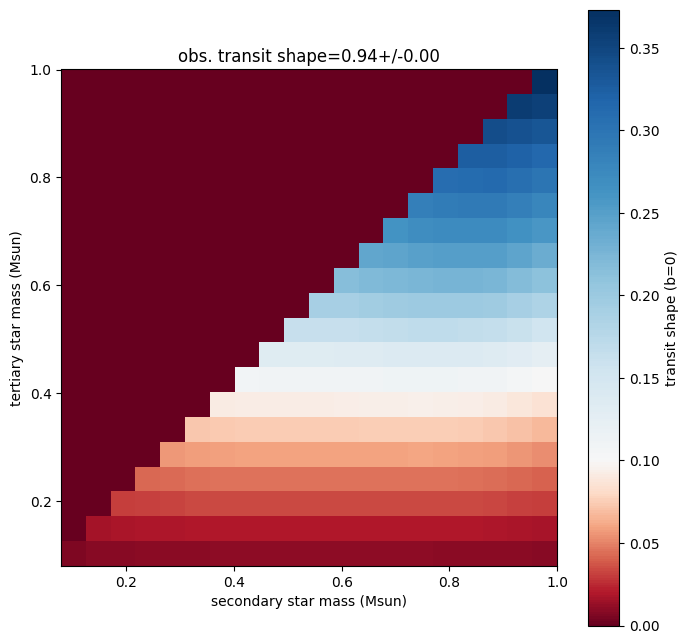

In [71]:
imp_par = 0

bp1, bp2 = 'Spitzer_I2', 'TESS'
label = f'transit shape (b={imp_par})'
grid = tshape_grids2[imp_par][bp1]

tshape = obs_tshapes[imp_par][bp1]
rtol = tshape.std_dev/tshape.nominal_value
idx = np.isclose(grid, tshape.nominal_value, rtol=rtol)

fig = plot_likelihood_grid(grid, 
                          m2s, m3s, 
                          reference=0.1,#tshape.nominal_value,
                          label=label, 
                          use_norm_cbar=False,
                          cmap='RdBu'
                         )
fig.axes[0].set_title(f"obs. transit shape={tshape:.2f}")

## reproduction

In [1]:
import numpy as np
import astropy.units as u
from isochrones import get_ichrone
mist_tracks = get_ichrone('mist', tracks=True)

In [2]:
#toi179
TEFF = 5058
FEH = -0.137198
LOGG = 4.564691
RSTAR = 0.838949
MSTAR = 0.815533
DISTANCE = 38.5

LOG10AGE = np.log10(600e6)
DEPTH_OBS = 0.0011345367429999999
DEPTH_OBS_ERR = 0.0005
AV= 0

In [3]:
mist_tracks.generate(MSTAR, LOG10AGE, FEH, distance=DISTANCE, AV=0, return_dict=True) 

{'logL': -0.45887943514039903,
 'density': 2.919205002095364,
 'mass': 0.8155241900303363,
 'radius': 0.7334459245561785,
 'eep': 273.70587972271994,
 'Mbol': 5.887198587850998,
 'delta_nu': 202.6397854254687,
 'nu_max': 4969.130906771914,
 'phase': 0.0,
 'Teff': 5179.8653579242955,
 'initial_mass': 0.8155329999999997,
 'feh': -0.10500573000998137,
 'logg': 4.618959612010775,
 'logTeff': 3.7140059042553615,
 'interpolated': 0.0,
 'star_age': 618874789.5719788,
 'age': 8.788412562146855,
 'dt_deep': 0.01436751017014461,
 'J_mag': 7.5417910996287985,
 'H_mag': 7.08669165257109,
 'K_mag': 7.029391087092193,
 'G_mag': 8.798662156151005,
 'BP_mag': 9.215778814032292,
 'RP_mag': 8.219599013897023,
 'W1_mag': 7.00871855949824,
 'W2_mag': 7.049257819163855,
 'W3_mag': 6.990343519998625,
 'TESS_mag': 8.210862235479933,
 'Kepler_mag': 8.700950121204952,
 'distance': 38.5,
 'AV': 0.0,
 'initial_feh': -0.137198,
 'requested_age': 8.778151250383644}

In [4]:
import chronos as cr

depth_true = cr.get_HEB_eclipse_depth_from_masses(
                                            mass1=MSTAR, 
                                            mass2=0.1, 
                                            mass3=0.1, 
                                            tracks=mist_tracks,
                                            log10age=LOG10AGE, 
                                            feh=FEH, F0=1, 
                                            band='TESS'
                                           )
depth_true

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


0.0018477957408060694

In [5]:
cr.transit.likelihood(depth_true, DEPTH_OBS, DEPTH_OBS_ERR)

104.27277838734896

## mass grid

### multi-band

In [6]:
bands = ['TESS_mag', 'J_mag', 'H_mag', 'K_mag']

N_samples = 20
m2s = np.linspace(0.05, 0.5, N_samples)
m3s = np.linspace(0.05, 0.5, N_samples)


mass_grids = cr.get_likelihoods_mass_grid(
                                        MSTAR+1,
                                        m2s,
                                        m3s,
                                        obs=(DEPTH_OBS, DEPTH_OBS_ERR),
                                        log10age=LOG10AGE,
                                        tracks=mist_tracks,
                                        feh=FEH,
                                        bands=bands,
                                        obs_min=0,
                                        obs_max=1
                                    )
mass_grids.keys()

dict_keys(['TESS_mag', 'J_mag', 'H_mag', 'K_mag'])

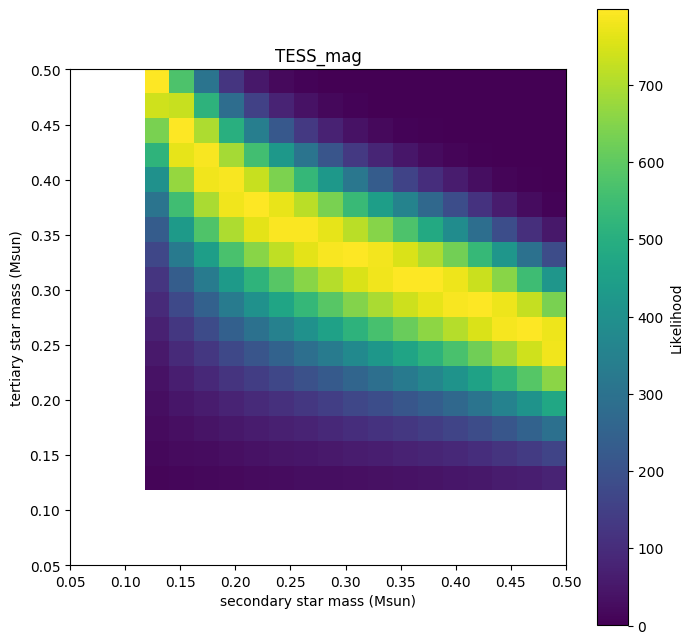

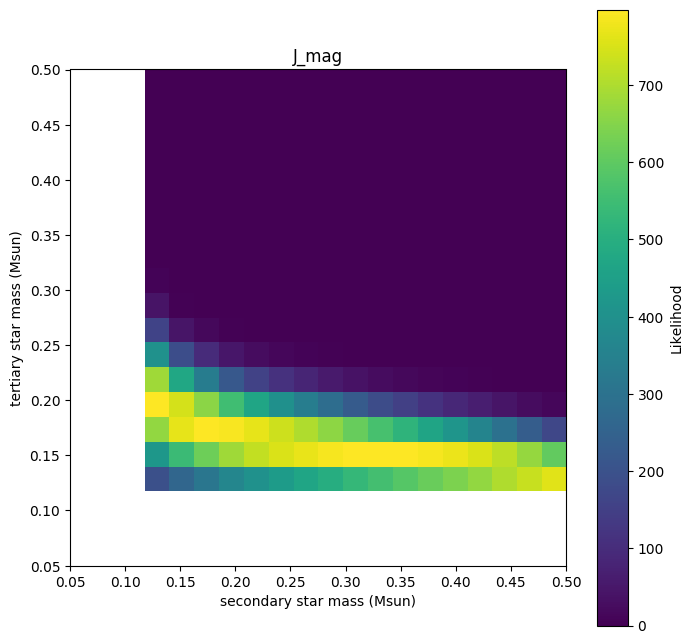

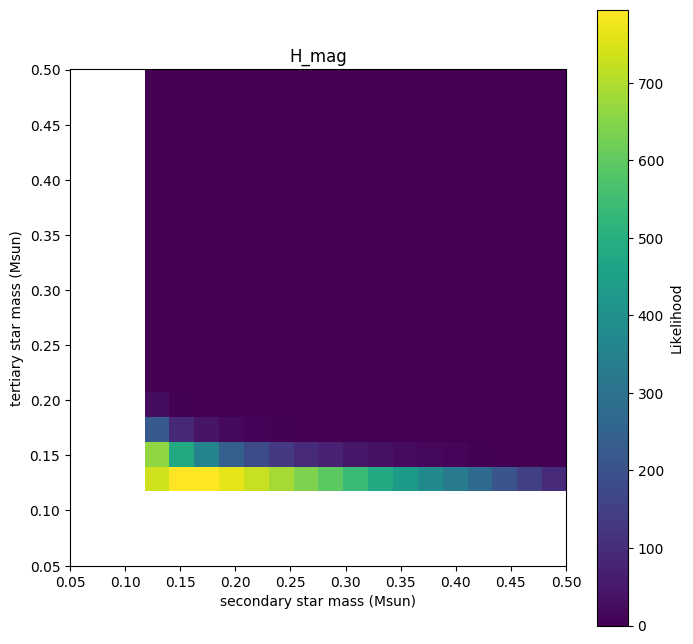

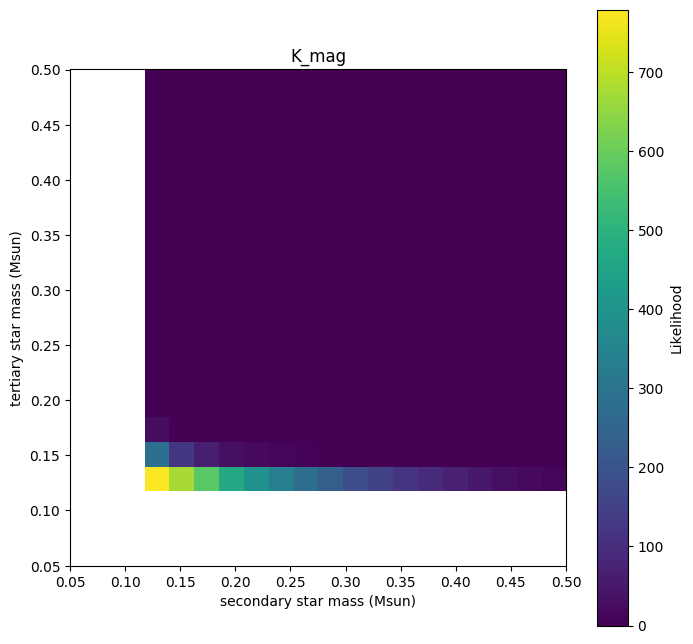

In [8]:
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

# eclipse shape constraint

In [9]:
import chronos as cr

p = cr.Planet(toiid=179)

Target: TOI 179
Searching Vizier: (44.262 -56.1919) with radius=3.0 arcsec


In [13]:
RpRs = 0.030770 #from johannes
TSHAPE = cr.transit.tshape_approx(RpRs, b=0.3)
TSHAPE_ERR1 = TSHAPE-cr.transit.tshape_approx(RpRs+0.001346, b=0.3)
TSHAPE_ERR2 = TSHAPE-cr.transit.tshape_approx(RpRs-0.001346, b=0.3)
TSHAPE_ERR = np.hypot(TSHAPE_ERR1, TSHAPE_ERR2)
TSHAPE, TSHAPE_ERR

(0.9345789800245038, 0.003915590980661443)

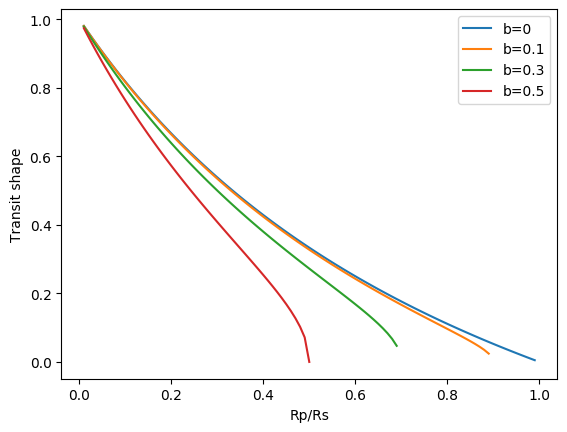

In [15]:
import matplotlib.pyplot as pl

ks = np.arange(0.01, 1, 0.01)

pl.plot(ks, cr.transit.tshape_approx(ks, b=0), label="b=0")
pl.plot(ks, cr.transit.tshape_approx(ks, b=0.1), label="b=0.1")
pl.plot(ks, cr.transit.tshape_approx(ks, b=0.3), label="b=0.3")
pl.plot(ks, cr.transit.tshape_approx(ks, b=0.5), label="b=0.5")
pl.xlabel('Rp/Rs')
pl.ylabel('Transit shape')
pl.legend()

## add tshape contraint from its posterior

In [16]:
import pandas as pd

tmodel_data1 = pd.read_csv('./johannes/no_priors/179.01-mcmc-samples.csv.gz')
# tmodel_data2 = pd.read_csv('./johannes/with_priors/179.01-mcmc-samples.csv.gz') 
tmodel_data1.columns

Index(['t0', 'p', 'k', 'a', 'b', 'q1', 'q2', 'c0', 'ls'], dtype='object')

In [17]:
tshape_post1 = cr.transit.tshape_approx(tmodel_data1.k,
                              b=tmodel_data1.b
                             )

In [18]:
tshape_lo, tshape_mid, tshape_hi = np.percentile(tshape_post1, [16,50,84])
tshape_mid, tshape_lo, tshape_hi

(0.9293077065989381, 0.8781032879497328, 0.9404899982363111)

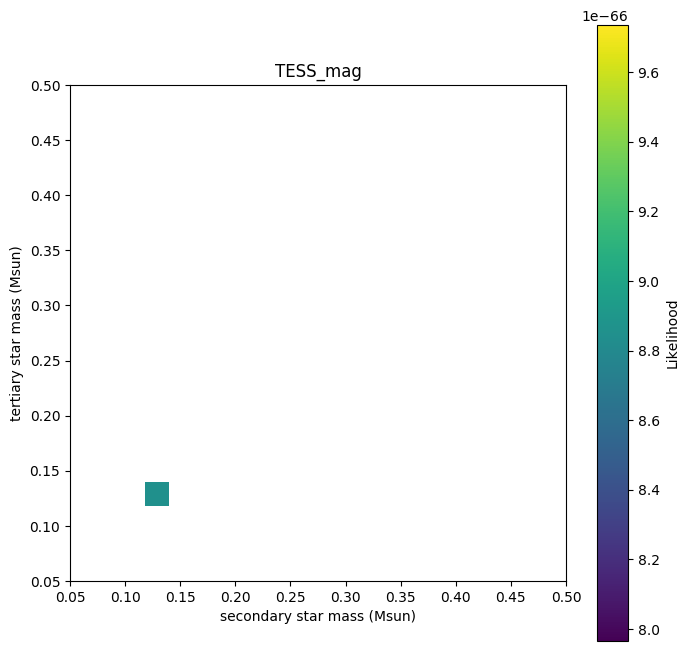

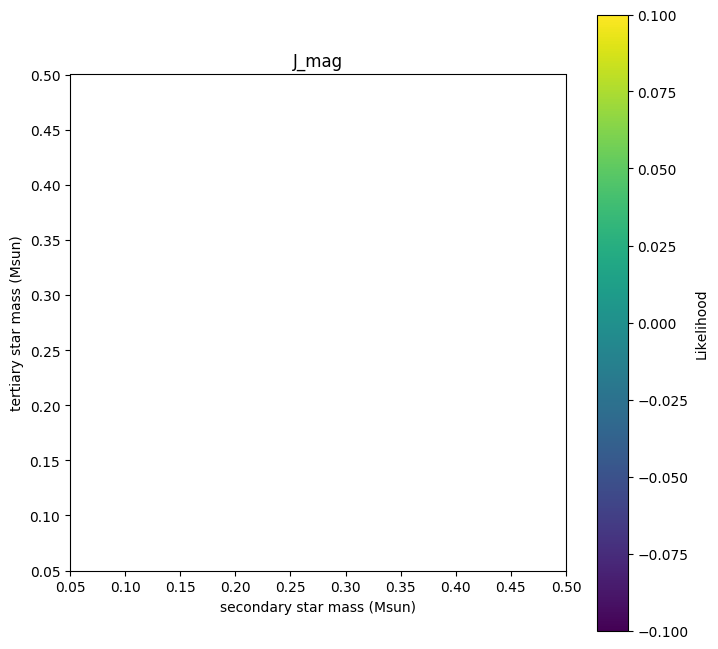

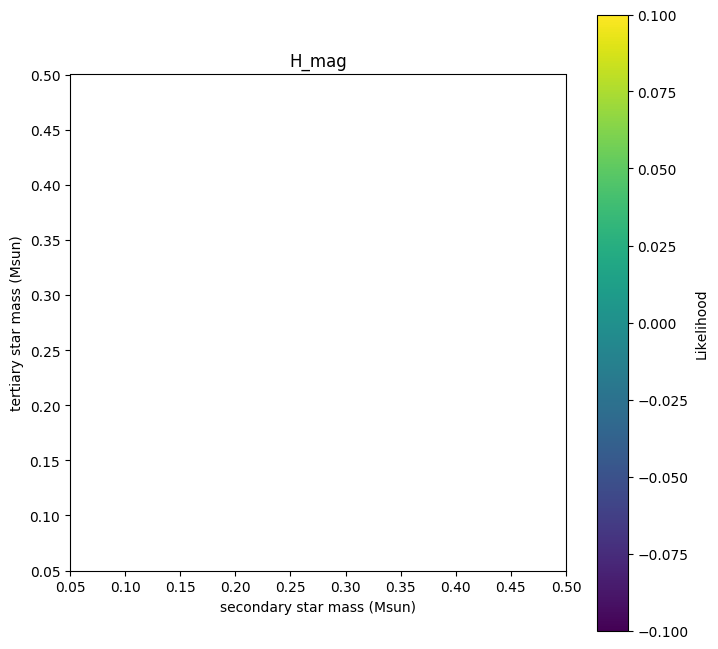

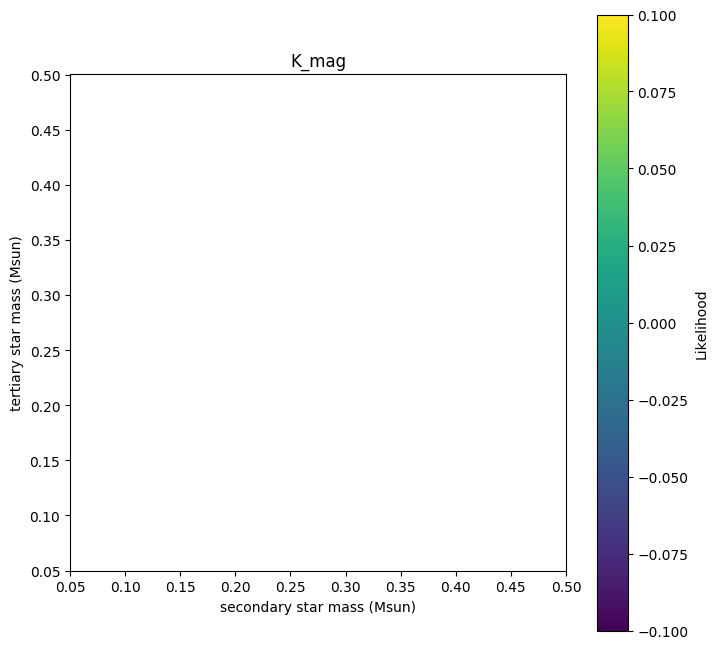

In [87]:
bands = ['TESS_mag', 'J_mag', 'H_mag', 'K_mag']

N_samples = 20
m2s = np.linspace(0.05, MSTAR, N_samples)
m3s = np.linspace(0.05, MSTAR, N_samples)


mass_grids2 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(TSHAPE, TSHAPE_ERR),
                                        log10age=LOG10AGE,
                                        tracks=mist_tracks,
                                        feh=FEH,
                                        bands=bands,
                                        use_tshape=True,
                                        b=0.3,
                                        obs_min=tshape_lo,
                                        obs_max=tshape_hi
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids2[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

## playground

### Jupiter around old, solar type primary star

* more massive primary requires higher secondary/tertiary mass ratios to reproduce an eclipse depth consistent with the observed transit depth
* deeper eclipse depths are produced with higher secondary/tertiary mass ratios
* eclipse depth for a given HEB observed in TESS band can be reproduced with another HEB having a smaller secondary/tertiary mass ratio observed in longer wavelengths (e.g. J)
* longer passbands rule out shallower eclipses
* smaller observation uncertainty yields narrower solutions of compatible systems

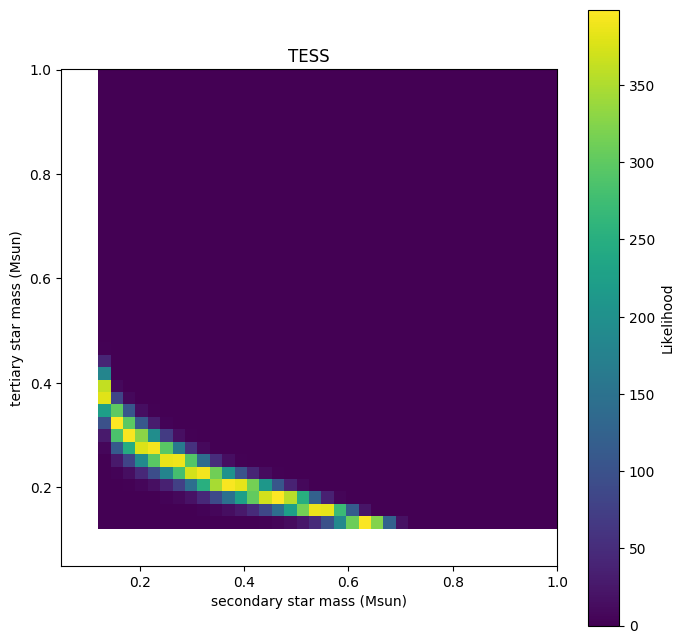

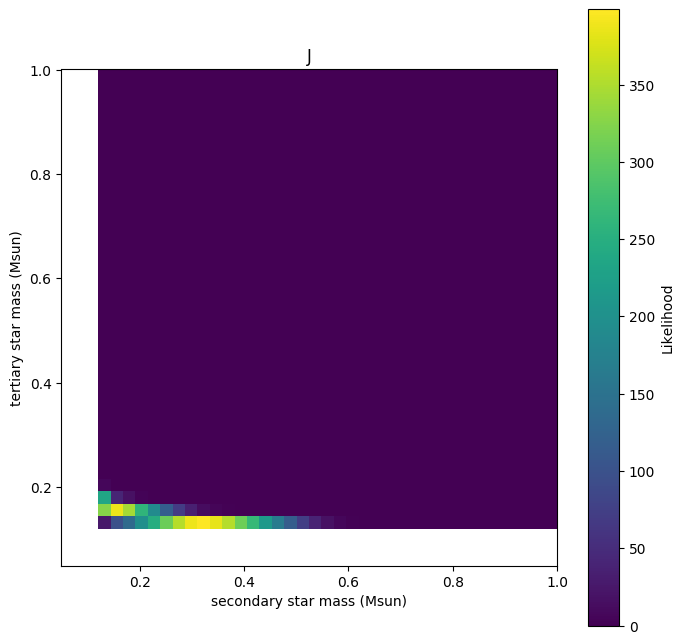

In [11]:
bands = ['TESS', 'J']

N_samples = 40
MSTAR = 1.0
m2s = np.linspace(0.05, MSTAR, N_samples)
m3s = np.linspace(0.05, MSTAR, N_samples)


mass_grids3 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(0.005, 0.001),
                                        log10age=9.653,
                                        tracks=mist_tracks,
                                        feh=0.012,
                                        bands=bands,
                                        use_tshape=False,
                                        b=0,
                                        obs_min=0,
                                        obs_max=1,
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids3[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

### with max_k constraint

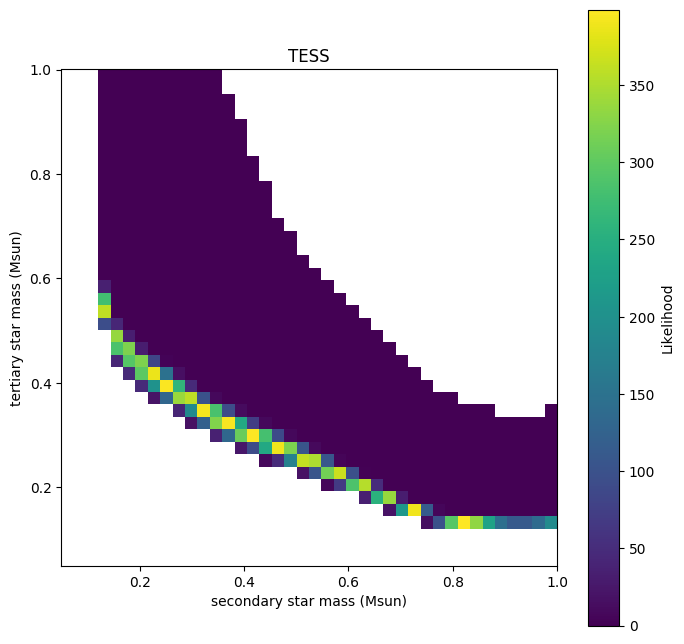

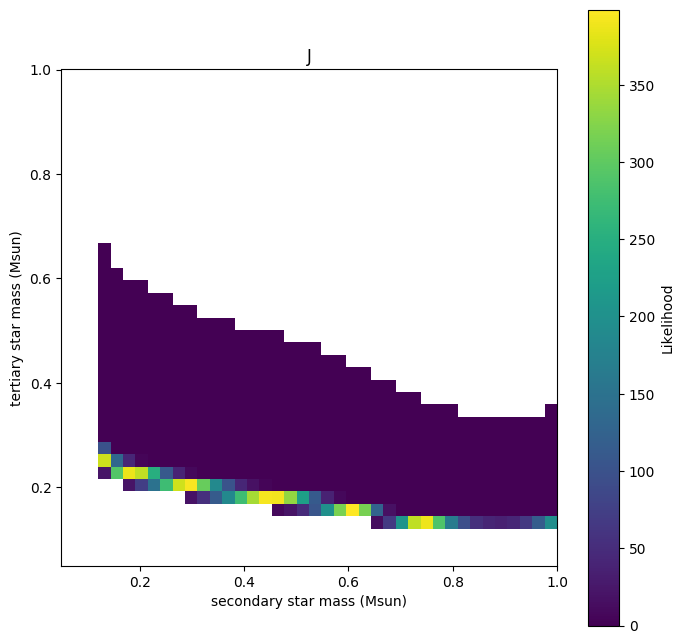

In [12]:
bands = ['TESS', 'J']

N_samples = 40
m2s = np.linspace(0.05, MSTAR, N_samples)
m3s = np.linspace(0.05, MSTAR, N_samples)

mass_grids3 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(0.01, 0.001),
                                        log10age=9.653,
                                        tracks=mist_tracks,
                                        feh=0.012,
                                        bands=bands,
                                        use_tshape=False,
                                        b=0,
                                        obs_min=0.008,
                                        obs_max=cr.transit.max_k(0.9),
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids3[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

### tshape

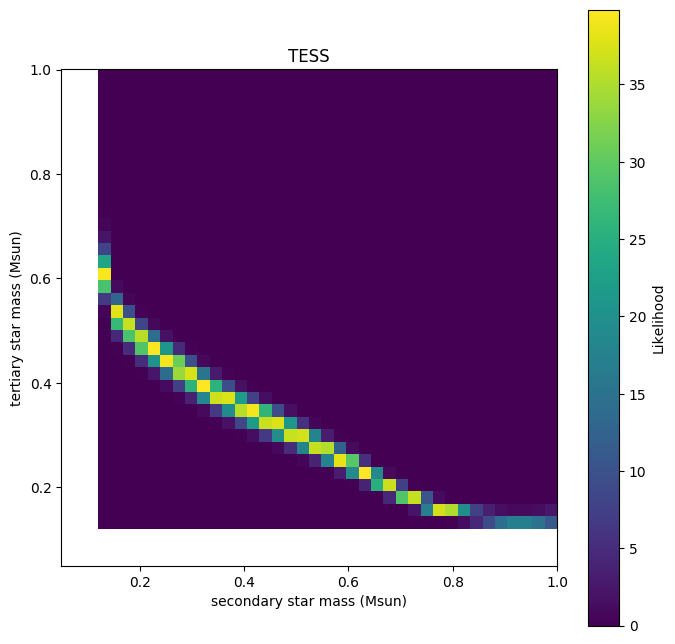

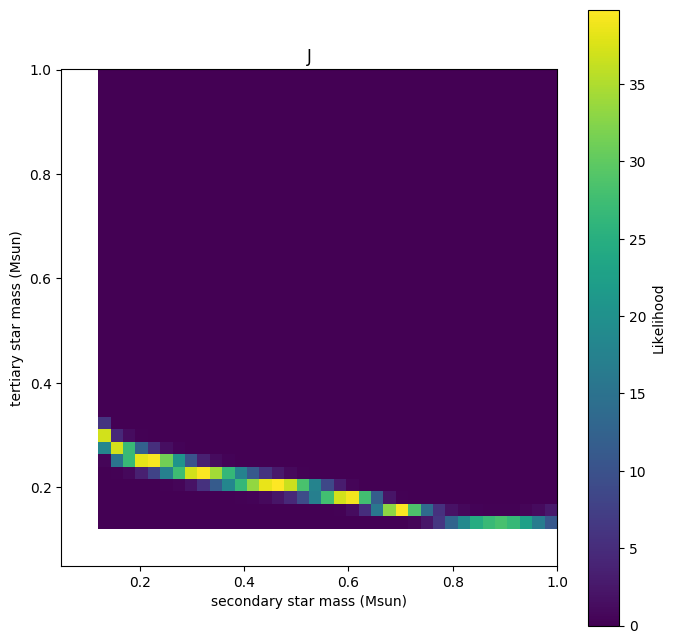

In [13]:
mass_grids3 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(0.8, 0.01),
                                        log10age=9.653,
                                        tracks=mist_tracks,
                                        feh=0.012,
                                        bands=bands,
                                        use_tshape=True,
                                        b=0,
                                        obs_min=0,
                                        obs_max=1,
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids3[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

### tshape constraint

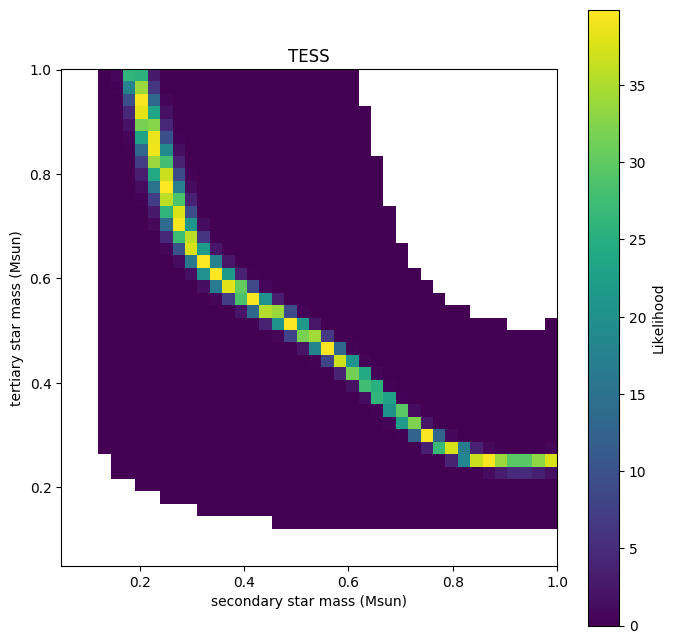

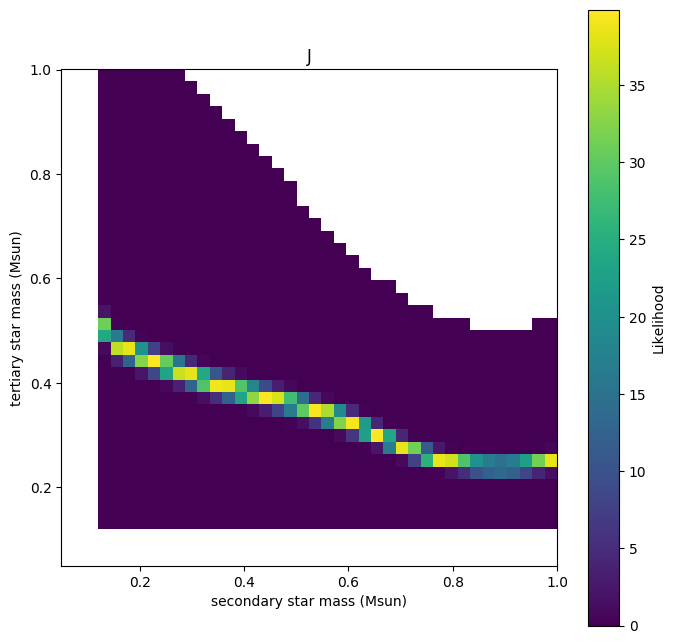

In [14]:
mass_grids3 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(0.7, 0.01),
                                        log10age=9.653,
                                        tracks=mist_tracks,
                                        feh=0.012,
                                        bands=bands,
                                        use_tshape=True,
                                        b=0,
                                        obs_min=0.5,
                                        obs_max=0.9,
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids3[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)

### eccentric orbit
* eclipse depth is calculated assuming b=0 for maximum; b>0 will yield shallower depths

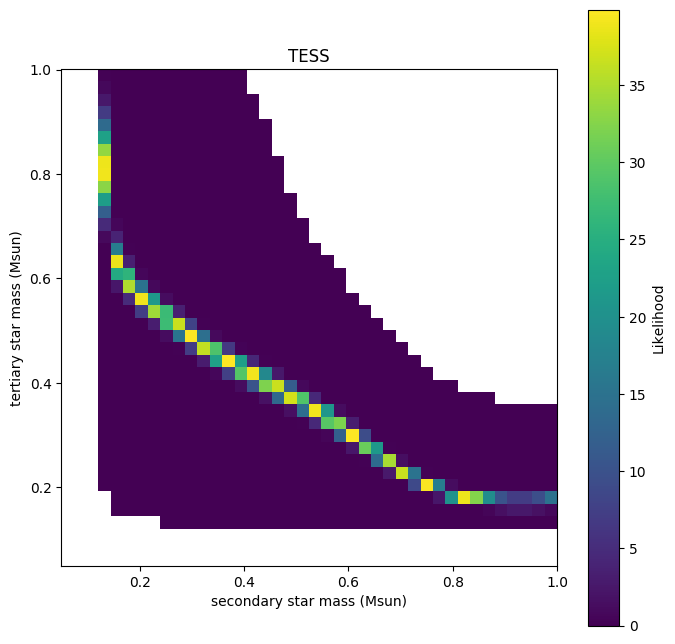

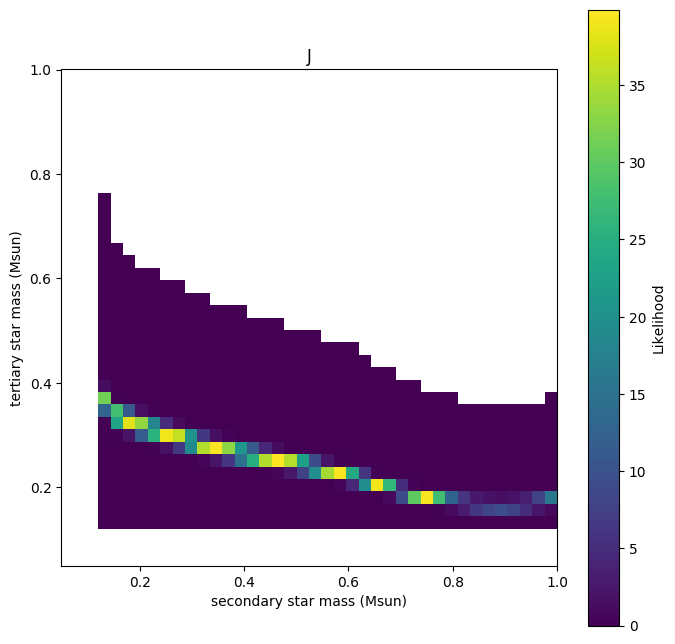

In [15]:
mass_grids3 = cr.get_likelihoods_mass_grid(
                                        MSTAR,
                                        m2s,
                                        m3s,
                                        obs=(0.7, 0.01),
                                        log10age=9.653,
                                        tracks=mist_tracks,
                                        feh=0.012,
                                        bands=bands,
                                        use_tshape=True,
                                        b=0.5,
                                        obs_min=0.5,
                                        obs_max=0.9,
                                    )
for bp in bands:
    fig = cr.plot_likelihood_grid(mass_grids3[bp], m2s, m3s, cmap='viridis')
    fig.axes[0].set_title(bp)